# Loading the data

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import os
plt.style.use('seaborn')
 

import warnings 
import tqdm
warnings.filterwarnings('ignore')
!pip install keras-tcn --no-dependencies

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))
from functools import partial
 

Sun Dec 19 10:40:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
df = pd.read_csv("dataset.csv")
df = df.iloc[:, 1:]

df['Time'] = pd.to_datetime(df['Time'])
df['Time'] = [(s-datetime.datetime(2015,5,1)).total_seconds() for s in df['Time']]
df['Time'] = df['Time']/1000

df

,Time,RTS_High,RTS_Low,RTS_Close,RTS_Volume,SBRF_High,SBRF_Low,SBRF_Close,SBRF_Volume,NG_High,NG_Low,NG_Close,NG_Volume,BR_Open,BR_High,BR_Low,BR_Close,BR_Volume,SI_High,SI_Low,SI_Close,SI_Volume,GOLD_High,GOLD_Low,GOLD_Close,GOLD_Volume,GAZR_High,GAZR_Low,GAZR_Close,GAZR_Volume
0,39131.7,92730.0,92680.0,92680.0,639,13803.0,13799.0,13803.0,169.0,2.678,2.678,2.678,12.0,44.93,44.95,44.92,44.93,13850.0,66636.0,66612.0,66628.0,7726.0,1323.0,1322.4,1322.5,159.0,14263.0,14263.0,14263.0,3.0
1,39132.0,92700.0,92630.0,92650.0,1342,13802.0,13797.0,13799.0,168.0,2.684,2.682,2.682,4.0,44.94,44.95,44.88,44.88,15897.0,66678.0,66624.0,66659.0,7914.0,1322.6,1322.3,1322.6,11.0,14267.0,14261.0,14263.0,34.0
2,39132.3,92720.0,92620.0,92640.0,1295,13802.0,13797.0,13800.0,94.0,2.687,2.685,2.687,82.0,44.89,44.91,44.88,44.89,2953.0,66667.0,66603.0,66665.0,11283.0,1322.8,1322.0,1322.2,35.0,14260.0,14258.0,14259.0,8.0
3,39132.6,92640.0,92550.0,92620.0,1802,13804.0,13792.0,13804.0,235.0,2.687,2.685,2.685,12.0,44.89,44.92,44.86,44.92,1302.0,66712.0,66658.0,66674.0,7226.0,1322.3,1322.0,1322.3,51.0,14260.0,14260.0,14260.0,21.0
4,39132.9,92620.0,92550.0,92580.0,496,13803.0,13796.0,13800.0,485.0,2.686,2.685,2.685,2.0,44.91,44.92,44.87,44.91,5868.0,66704.0,66672.0,66683.0,2567.0,1322.7,1322.4,1322.6,40.0,14260.0,14258.0,14258.0,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95495,112790.1,108970.0,108540.0,108650.0,11990,19613.0,19535.0,19546.0,8634.0,4.127,4.076,4.104,637.0,60.03,60.03,59.68,59.75,36531.0,66728.0,66666.0,66712.0,20767.0,1229.7,1229.0,1229.1,285.0,15086.0,14988.0,15005.0,3773.0
95496,112790.4,108720.0,108060.0,108200.0,18472,19559.0,19481.0,19499.0,10729.0,4.110,4.082,4.089,183.0,59.75,59.88,59.74,59.82,12470.0,66756.0,66703.0,66750.0,25472.0,1229.6,1229.1,1229.6,82.0,15007.0,14930.0,14943.0,4430.0
95497,112790.7,108210.0,107530.0,107650.0,21618,19501.0,19408.0,19419.0,14406.0,4.088,4.062,4.067,331.0,59.83,59.85,59.70,59.76,8648.0,66844.0,66743.0,66815.0,35637.0,1229.3,1228.8,1229.0,155.0,14941.0,14711.0,14823.0,19267.0
95498,112791.0,108020.0,107620.0,107920.0,8610,19518.0,19413.0,19462.0,10822.0,4.074,4.046,4.047,396.0,59.76,59.88,59.70,59.86,8159.0,66848.0,66776.0,66803.0,15689.0,1229.5,1228.7,1229.5,168.0,14859.0,14806.0,14858.0,3586.0


# Label Generation

In [8]:
df['R'] = np.zeros(len(df.Time))
df['L'] = np.zeros(len(df.Time))

window = 12
for i in range(len(df.Time) - window -1):
  df_slice = df[i : i+window + 1]
  df.R[i] = np.max(df_slice.RTS_High) - df.RTS_Close[i]
  df.L[i] = df.RTS_Close[i] - np.min(df_slice.RTS_Low)
  if not (i % int((len(df.Time) - window -1)/10)):
    print(f'step 1 - done {int(1 + 100 * i / (len(df.Time) - window - 1))} %')

R_max = df['R'].mean(axis=0)
L_max = df['L'].mean(axis=0)
for i in range(len(df.Time) - window -1):
  df_slice = df[i : i+window + 1]
  df.R[i] = df.R[i] / R_max
  df.L[i] = df.L[i] / L_max
  if not (i % int((len(df.Time) - window -1)/10)):
    print(f'step 2 - done {int(1 + 100* i / (len(df.Time) - window - 1))} % ')

def alt_sigmoid(x):
  return 1/(1+0.1 * np.exp(4-x))

step 1 - done 1 %
step 1 - done 10 %
step 1 - done 20 %
step 1 - done 30 %
step 1 - done 40 %
step 1 - done 50 %
step 1 - done 60 %
step 1 - done 70 %
step 1 - done 80 %
step 1 - done 90 %
step 1 - done 100 %
step 2 - done 1 % 
step 2 - done 10 % 
step 2 - done 20 % 
step 2 - done 30 % 
step 2 - done 40 % 
step 2 - done 50 % 
step 2 - done 60 % 
step 2 - done 70 % 
step 2 - done 80 % 
step 2 - done 90 % 
step 2 - done 100 % 


In [9]:
from scipy.signal import savgol_filter

df['Label'] = np.zeros(len(df.Time))
window = 12 #12 timeframes to see check ahead 
for i in range(len(df.Time)-(window + 1)):
  df_slice = df[i : i+window + 1]
  R = np.max(df_slice.RTS_High) - df.RTS_Close[i]
  L = df.RTS_Close[i] - np.min(df_slice.RTS_Low)
  pot = (R - L) / (R+L)
  if pot > 0:
    df['Label'][i] = pot * alt_sigmoid(df.R[i])
  elif pot < 0:
    df['Label'][i] = pot * alt_sigmoid(df.L[i])
  if not (i % int((len(df.Time) - window -1) /10)):
    print(f'step 1 - done {int(1 + 100* i / (len(df.Time) - window - 1))} % ')

del df['R']
del df['L']

df = df[0:len(df) - len(df_slice)-1] #done to exclude non-labeled part

df['Label'] = savgol_filter(df.Label, window_length = 11, polyorder = 2, deriv = 0)

step 1 - done 1 % 
step 1 - done 10 % 
step 1 - done 20 % 
step 1 - done 30 % 
step 1 - done 40 % 
step 1 - done 50 % 
step 1 - done 60 % 
step 1 - done 70 % 
step 1 - done 80 % 
step 1 - done 90 % 
step 1 - done 100 % 


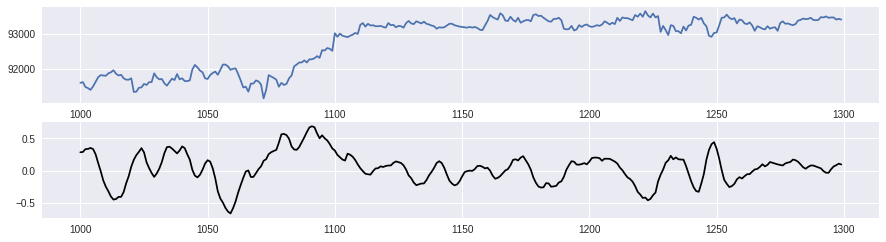

<Figure size 1296x360 with 0 Axes>

In [10]:
fig = plt.figure(figsize=(15,6))

st = 1000
p = 300

plt.figure(figsize=(18, 5))
ax10 = fig.add_subplot(311)
ax10.plot(df.RTS_Close[st:st+p])

#Plot training data results
ax11 = fig.add_subplot(312)
ax11.plot(df.Label[st:st+p], color='black')


In this labelling system positive values mean that a purchase should be made, while negative values mean that one would be better off selling the asset.
We also adjust for volatility to value larger moves more.

# Data Preparation for training

In [11]:
'''Calculate percentage change'''
 
df['RTS_High'] = df['RTS_High'].pct_change() # Create arithmetic returns column
df['RTS_Low'] = df['RTS_Low'].pct_change() # Create arithmetic returns column
df['RTS_Close'] = df['RTS_Close'].pct_change() # Create arithmetic returns column
df['RTS_Volume'] = df['RTS_Volume'].pct_change()
 
df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values
 
###############################################################################
'''Normalize price columns'''

min_return = min(df[['RTS_High', 'RTS_Low', 'RTS_Close']][:int(0.8 * len(df))].min(axis=0))
max_return = max(df[['RTS_High', 'RTS_Low', 'RTS_Close']][:int(0.8 * len(df))].max(axis=0))
 
# Min-max normalize price columns (0-1 range)
df['RTS_High'] = (df['RTS_High'] - min_return) / (max_return - min_return)
df['RTS_Low'] = (df['RTS_Low'] - min_return) / (max_return - min_return)
df['RTS_Close'] = (df['RTS_Close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''
 
min_volume = df['RTS_Volume'][:int(0.8 * len(df))].min(axis=0)
max_volume = df['RTS_Volume'][:int(0.8 * len(df))].max(axis=0)
 
# Min-max normalize volume columns (0-1 range)
df['RTS_Volume'] = (df['RTS_Volume'] - min_volume) / (max_volume - min_volume)
 
###############################################################################

In [12]:
'''Create training, validation and test split'''
 
times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-4000] # Last 4000
last_20pct = sorted(df.index.values)[-8000] # Last 8000
 
df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]
 
# Remove date column
# df_train.drop(columns=['Time'], inplace=True)
# df_val.drop(columns=['Time'], inplace=True)
# df_test.drop(columns=['Time'], inplace=True)
 
# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))
 
df_train.head()

Training data shape: (87485, 31)
Validation data shape: (4000, 31)
Test data shape: (4000, 31)


,Time,RTS_High,RTS_Low,RTS_Close,RTS_Volume,SBRF_High,SBRF_Low,SBRF_Close,SBRF_Volume,NG_High,NG_Low,NG_Close,NG_Volume,BR_Open,BR_High,BR_Low,BR_Close,BR_Volume,SI_High,SI_Low,SI_Close,SI_Volume,GOLD_High,GOLD_Low,GOLD_Close,GOLD_Volume,GAZR_High,GAZR_Low,GAZR_Close,GAZR_Volume,Label
1,39132.0,0.548030,0.544652,0.548027,0.000157,13802.0,13797.0,13799.0,168.0,2.684,2.682,2.682,4.0,44.94,44.95,44.88,44.88,15897.0,66678.0,66624.0,66659.0,7914.0,1322.6,1322.3,1322.6,11.0,14267.0,14261.0,14263.0,34.0,-0.026133
2,39132.3,0.556464,0.551401,0.551402,0.000072,13802.0,13797.0,13800.0,94.0,2.687,2.685,2.687,82.0,44.89,44.91,44.88,44.89,2953.0,66667.0,66603.0,66665.0,11283.0,1322.8,1322.0,1322.2,35.0,14260.0,14258.0,14259.0,8.0,0.040590
3,39132.6,0.539595,0.541269,0.549713,0.000104,13804.0,13792.0,13804.0,235.0,2.687,2.685,2.685,12.0,44.89,44.92,44.86,44.92,1302.0,66712.0,66658.0,66674.0,7226.0,1322.3,1322.0,1322.3,51.0,14260.0,14260.0,14260.0,21.0,0.089549
4,39132.9,0.549713,0.553090,0.546335,0.000021,13803.0,13796.0,13800.0,485.0,2.686,2.685,2.685,2.0,44.91,44.92,44.87,44.91,5868.0,66704.0,66672.0,66683.0,2567.0,1322.7,1322.4,1322.6,40.0,14260.0,14258.0,14258.0,41.0,0.120742
5,39133.2,0.556467,0.553090,0.548022,0.000123,13807.0,13798.0,13798.0,195.0,2.686,2.685,2.685,2.0,44.91,44.93,44.87,44.89,2398.0,66690.0,66667.0,66685.0,2172.0,1322.9,1322.7,1322.8,61.0,14263.0,14258.0,14258.0,60.0,0.134170


In [13]:
seq_len = 128
 
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[:, :len(df.columns)-1][i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, len(df.columns)-1][i-1]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)
 
###############################################################################
 
# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[:, :len(df.columns)-1][i-seq_len:i])
    y_val.append(val_data[:, len(df.columns)-1][i-1])
X_val, y_val = np.array(X_val), np.array(y_val)
 
###############################################################################
 
# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[:, :len(df.columns)-1][i-seq_len:i])
    y_test.append(test_data[:, len(df.columns)-1][i-1])    
X_test, y_test = np.array(X_test), np.array(y_test)
 
print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape, "y_val_shape:", y_val.shape)

X_train shape: (87357, 128, 30) y_train shape: (87357,)
X_val shape: (3872, 128, 30) y_val_shape: (3872,)


# T2V + Basic LSTM Model

In [9]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer

class T2V(Layer):
    
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.W = self.add_weight(name='W', shape=(input_shape[-1], self.output_dim), 
                                 initializer='uniform', trainable=True)
        self.P = self.add_weight(name='P', shape=(input_shape[1], self.output_dim), 
                                 initializer='uniform', trainable=True)
        self.w = self.add_weight(name='w', shape=(input_shape[1], 1), 
                                 initializer='uniform', trainable=True)
        self.p = self.add_weight(name='p', shape=(input_shape[1], 1), 
                                 initializer='uniform', trainable=True)
        super(T2V, self).build(input_shape)
    
    def call(self, x):
        original = self.w * x + self.p
        sin_trans = K.sin(K.dot(x, self.W) + self.P)
        return K.concatenate([sin_trans, original], -1)

In [37]:
def make_model(cell_size = 128):

    inp = Input(shape=(seq_len,X_train.shape[2]))
    x = BatchNormalization()(inp)
    x = T2V(4)(x)

    x = LSTM(cell_size, return_sequences = False)(x)
    x = BatchNormalization()(x)

    x = Dense(128, activation = partial(tf.nn.leaky_relu, alpha=0.01))(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation = partial(tf.nn.leaky_relu, alpha=0.01))(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation = partial(tf.nn.leaky_relu, alpha=0.01))(x)
    out = Dense(1)(x)
    model = Model(inp, out)
    model.compile(loss='mse', 
                  optimizer=tf.keras.optimizers.Adam(), 
                  metrics = ['mae'])
    return model

# Training

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 30)]         0         
                                                                 
 batch_normalization (BatchN  (None, 128, 30)          120       
 ormalization)                                                   
                                                                 
 t2v (T2V)                   (None, 128, 34)           888       
                                                                 
 lstm (LSTM)                 (None, 128)               83456     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 128)               16512 

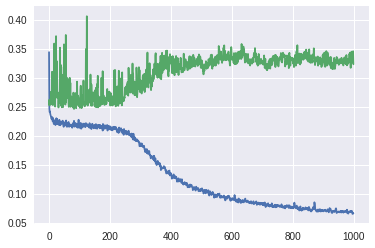

In [43]:
tf.keras.backend.clear_session()
model = make_model()
model.summary()

history = model.fit(X_train, y_train,
          epochs=1000,
          validation_data=(X_val, y_val),
          batch_size = 125, 
          verbose = 1,
          steps_per_epoch=40
          )

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])

121/121 [==============================] - 1s 4ms/step - loss: 0.1357 - mae: 0.2955


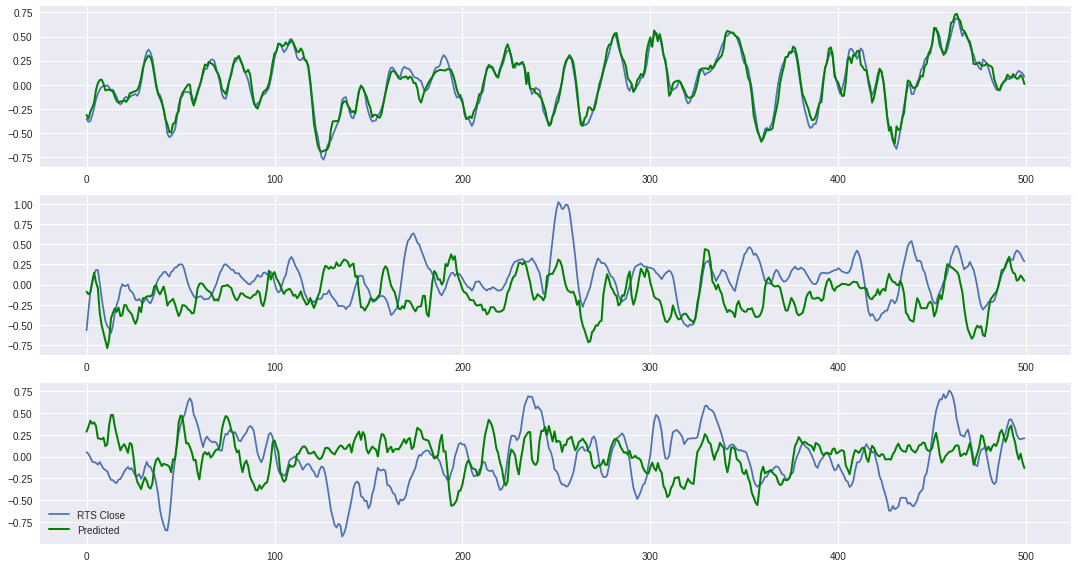

In [52]:
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

train_eval = model.evaluate(X_train, y_train, verbose=1)
val_eval = model.evaluate(X_val, y_val, verbose=1)
test_eval = model.evaluate(X_test, y_test, verbose=1)

fig = plt.figure(figsize=(15,8))
 
st = 500
p = 500
 
ax11 = fig.add_subplot(311)
ax11.plot(y_train[st: st+p], label='RTS Close')
ax11.plot(train_pred[st:st+p], color='green', linewidth=2, label='Predicted')
ax21 = fig.add_subplot(312)
ax21.plot(y_val[st: st+p], label='RTS Close')
ax21.plot(val_pred[st: st+p], color='green', linewidth=2, label='Predicted')
ax31 = fig.add_subplot(313)
ax31.plot(y_test[st: st+p], label='RTS Close')
ax31.plot(test_pred[st: st+p], color='green', linewidth=2, label='Predicted')
 
plt.tight_layout()
plt.legend(loc='best')

model.save_weights("part2_models/simple_lstm.ckpt")
#model.load_weights("part2_models/simple_lstm.ckpt")

# Evaluation

121/121 [==============================] - 1s 4ms/step - loss: 0.1357 - mae: 0.2955


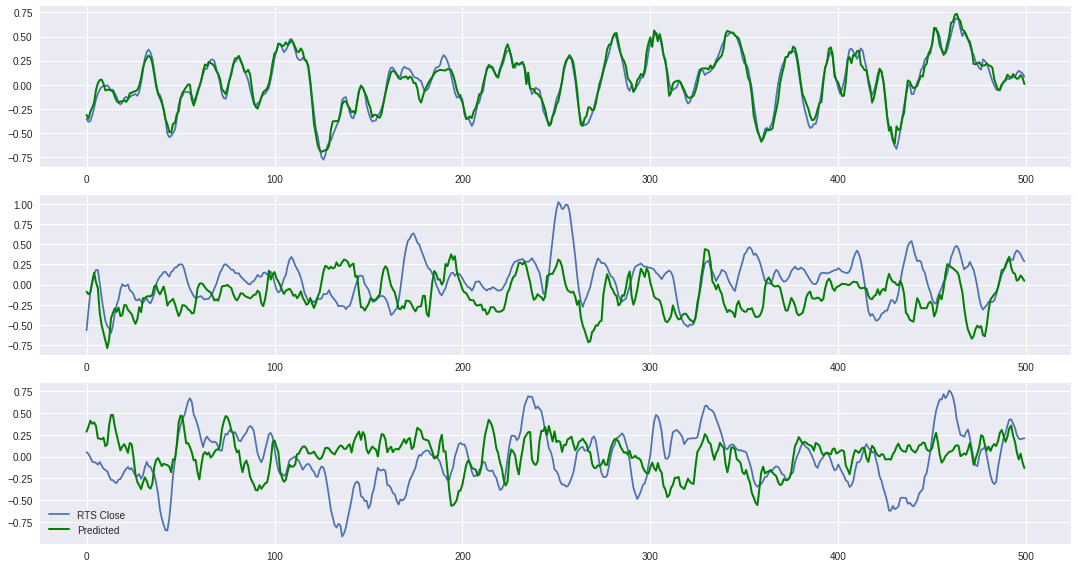

In [ ]:
model.load_weights("part2_models/simple_lstm/simple_lstm.ckpt")

train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

train_eval = model.evaluate(X_train, y_train, verbose=1)
val_eval = model.evaluate(X_val, y_val, verbose=1)
test_eval = model.evaluate(X_test, y_test, verbose=1)

fig = plt.figure(figsize=(15,8))
 
st = 500
p = 500
 
ax11 = fig.add_subplot(311)
ax11.plot(y_train[st: st+p], label='RTS Close')
ax11.plot(train_pred[st:st+p], color='green', linewidth=2, label='Predicted')
ax21 = fig.add_subplot(312)
ax21.plot(y_val[st: st+p], label='RTS Close')
ax21.plot(val_pred[st: st+p], color='green', linewidth=2, label='Predicted')
ax31 = fig.add_subplot(313)
ax31.plot(y_test[st: st+p], label='RTS Close')
ax31.plot(test_pred[st: st+p], color='green', linewidth=2, label='Predicted')
 
plt.tight_layout()
plt.legend(loc='best')


# T2V + Temporal ConvNet

In [58]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer

class T2V(Layer):
    
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.W = self.add_weight(name='W', shape=(input_shape[-1], self.output_dim), 
                                 initializer='uniform', trainable=True)
        self.P = self.add_weight(name='P', shape=(input_shape[1], self.output_dim), 
                                 initializer='uniform', trainable=True)
        self.w = self.add_weight(name='w', shape=(input_shape[1], 1), 
                                 initializer='uniform', trainable=True)
        self.p = self.add_weight(name='p', shape=(input_shape[1], 1), 
                                 initializer='uniform', trainable=True)
        super(T2V, self).build(input_shape)
    
    def call(self, x):
        original = self.w * x + self.p
        sin_trans = K.sin(K.dot(x, self.W) + self.P)
        return K.concatenate([sin_trans, original], -1)

In [67]:
# !pip install keras-tcn --no-dependencies
from tcn import TCN, tcn_full_summary

def make_model():

    tcn_layer = TCN(
        nb_filters=80,
        kernel_size=3,
        nb_stacks=1,
        dilations=(1, 4, 16),
        padding='causal',
        use_skip_connections=True,
        dropout_rate=0.0,
        return_sequences=False,
        activation=partial(tf.nn.leaky_relu, alpha=0.01),
        kernel_initializer='he_normal',
        use_batch_norm=True,
        use_layer_norm=False,
        use_weight_norm=False
        )

    inp = Input(shape=(seq_len,X_train.shape[2]))

    x = BatchNormalization()(inp)
    time = Lambda(lambda x: x[:, :, :1])(x)
    feat = Lambda(lambda x: x[:, :, 1:X_train.shape[2]])(x)
    x = T2V(4)(time)
    x = Concatenate()([x, feat])

    x = BatchNormalization()(x)

    x = tcn_layer(x)
    x = BatchNormalization()(x)

    x = Dense(80, activation = partial(tf.nn.leaky_relu, alpha=0.01))(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation = partial(tf.nn.leaky_relu, alpha=0.01))(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation = partial(tf.nn.leaky_relu, alpha=0.01))(x)
    out = Dense(1)(x)
    model = Model(inp, out)
    model.compile(loss='mse', 
                  optimizer=tf.keras.optimizers.Adam(), 
                  metrics = ['mae'])
    return model

In [68]:
tf.keras.backend.clear_session()
model = make_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 30)]    0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 30)     120         ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 lambda (Lambda)                (None, 128, 1)       0           ['batch_normalization[0][0]']    
                                                                                                  
 t2v (T2V)                      (None, 128, 5)       772         ['lambda[0][0]']             

# Training

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 30)]    0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 30)     120         ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 lambda (Lambda)                (None, 128, 1)       0           ['batch_normalization[0][0]']    
                                                                                                  
 t2v (T2V)                      (None, 128, 5)       772         ['lambda[0][0]']             

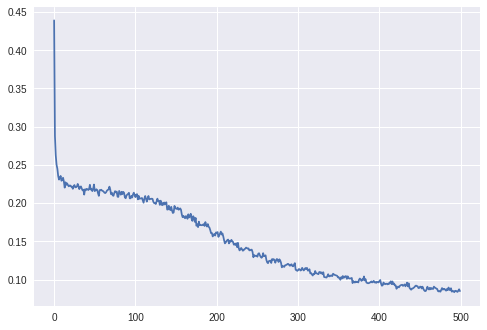

In [69]:
tf.keras.backend.clear_session()
model = make_model()
model.summary()

history = model.fit(X_train, y_train,
          epochs=500,
          #validation_data=(X_val, y_val),
          batch_size = 125, 
          verbose = 1,
          steps_per_epoch=40
          )

plt.plot(history.history['mae'])

121/121 [==============================] - 1s 5ms/step - loss: 0.1399 - mae: 0.2955


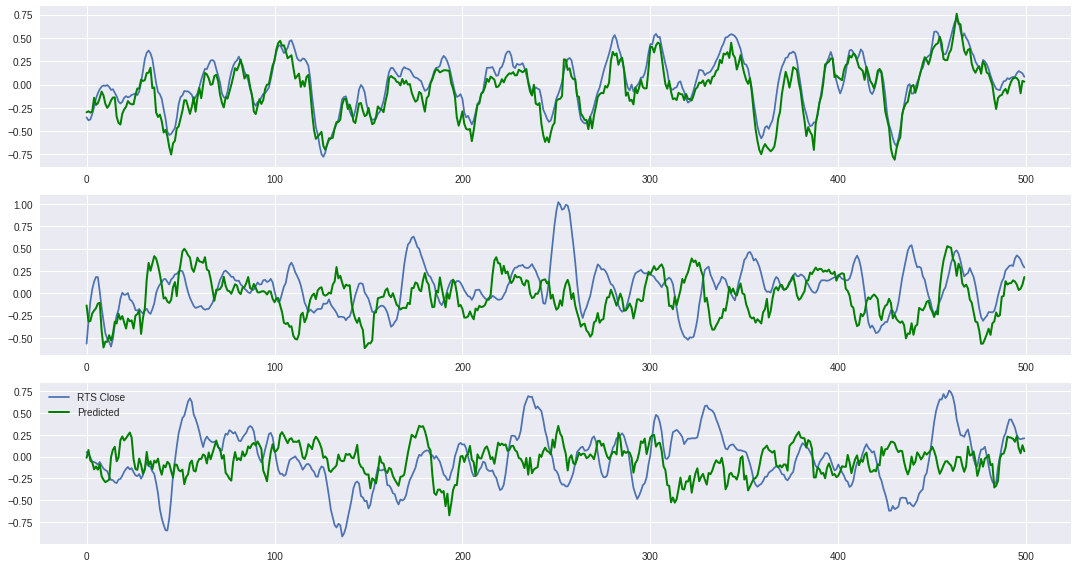

In [70]:
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

train_eval = model.evaluate(X_train, y_train, verbose=1)
val_eval = model.evaluate(X_val, y_val, verbose=1)
test_eval = model.evaluate(X_test, y_test, verbose=1)

fig = plt.figure(figsize=(15,8))
 
st = 500
p = 500
 
ax11 = fig.add_subplot(311)
ax11.plot(y_train[st: st+p], label='RTS Close')
ax11.plot(train_pred[st:st+p], color='green', linewidth=2, label='Predicted')
ax21 = fig.add_subplot(312)
ax21.plot(y_val[st: st+p], label='RTS Close')
ax21.plot(val_pred[st: st+p], color='green', linewidth=2, label='Predicted')
ax31 = fig.add_subplot(313)
ax31.plot(y_test[st: st+p], label='RTS Close')
ax31.plot(test_pred[st: st+p], color='green', linewidth=2, label='Predicted')
 
plt.tight_layout()
plt.legend(loc='best')

model.save_weights("part2_models/simple_tcn.ckpt")
#model.load_weights("part2_models/simple_lstm.ckpt")

# Evaluation

121/121 [==============================] - 1s 5ms/step - loss: 0.1399 - mae: 0.2955


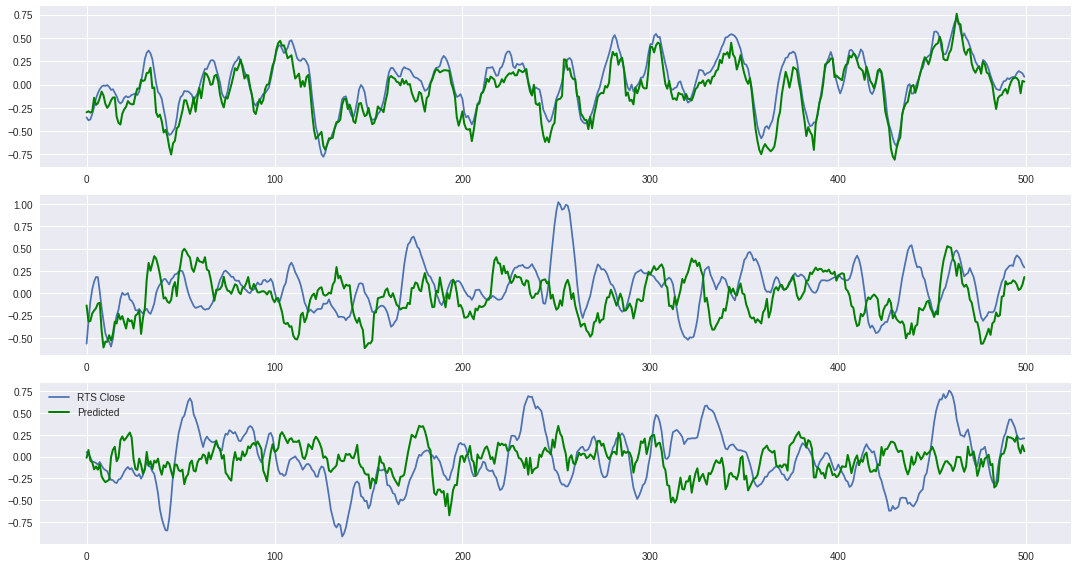

In [ ]:
model.load_weights("part2_models/simple_tcn/simple_tcn.ckpt")

train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

train_eval = model.evaluate(X_train, y_train, verbose=1)
val_eval = model.evaluate(X_val, y_val, verbose=1)
test_eval = model.evaluate(X_test, y_test, verbose=1)

fig = plt.figure(figsize=(15,8))
 
st = 500
p = 500
 
ax11 = fig.add_subplot(311)
ax11.plot(y_train[st: st+p], label='RTS Close')
ax11.plot(train_pred[st:st+p], color='green', linewidth=2, label='Predicted')
ax21 = fig.add_subplot(312)
ax21.plot(y_val[st: st+p], label='RTS Close')
ax21.plot(val_pred[st: st+p], color='green', linewidth=2, label='Predicted')
ax31 = fig.add_subplot(313)
ax31.plot(y_test[st: st+p], label='RTS Close')
ax31.plot(test_pred[st: st+p], color='green', linewidth=2, label='Predicted')
 
plt.tight_layout()
plt.legend(loc='best')


# T2V Conv1D + LSTM

In [54]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer

class T2V(Layer):
    
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.W = self.add_weight(name='W', shape=(input_shape[-1], self.output_dim), 
                                 initializer='uniform', trainable=True)
        self.P = self.add_weight(name='P', shape=(input_shape[1], self.output_dim), 
                                 initializer='uniform', trainable=True)
        self.w = self.add_weight(name='w', shape=(input_shape[1], 1), 
                                 initializer='uniform', trainable=True)
        self.p = self.add_weight(name='p', shape=(input_shape[1], 1), 
                                 initializer='uniform', trainable=True)
        super(T2V, self).build(input_shape)
    
    def call(self, x):
        original = self.w * x + self.p
        sin_trans = K.sin(K.dot(x, self.W) + self.P)
        return K.concatenate([sin_trans, original], -1)

In [55]:
def make_model(cell_size = 96):

    inp = Input(shape=(seq_len,X_train.shape[2]))
    x = BatchNormalization()(inp)
    time = Lambda(lambda x: x[:, :, :1])(x)
    feat = Lambda(lambda x: x[:, :, 1:X_train.shape[2]])(x)
    x = T2V(4)(time)
    x = Concatenate()([x, feat])

    x = Conv1D(32, kernel_size = 3, padding = "same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(32, kernel_size = 3, padding = "same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(64, kernel_size = 3, padding = "same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    

    x = LSTM(cell_size, return_sequences = False)(x)
    x = BatchNormalization()(x)

    x = Dense(96, activation = partial(tf.nn.leaky_relu, alpha=0.01))(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation = partial(tf.nn.leaky_relu, alpha=0.01))(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation = partial(tf.nn.leaky_relu, alpha=0.01))(x)
    out = Dense(1)(x)
    model = Model(inp, out)
    model.compile(loss='mse', 
                  optimizer=tf.keras.optimizers.Adam(), 
                  metrics = ['mae'])
    return model

# Training Part

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 30)]    0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 30)     120         ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 lambda (Lambda)                (None, 128, 1)       0           ['batch_normalization[0][0]']    
                                                                                                  
 t2v (T2V)                      (None, 128, 5)       772         ['lambda[0][0]']             

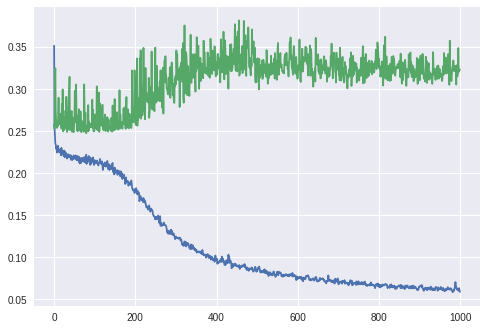

In [56]:
tf.keras.backend.clear_session()
model = make_model()
model.summary()

history = model.fit(X_train, y_train,
          epochs=1000,
          validation_data=(X_val, y_val),
          batch_size = 125, 
          verbose = 1,
          steps_per_epoch=40
          )

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])

121/121 [==============================] - 1s 6ms/step - loss: 0.1606 - mae: 0.3128


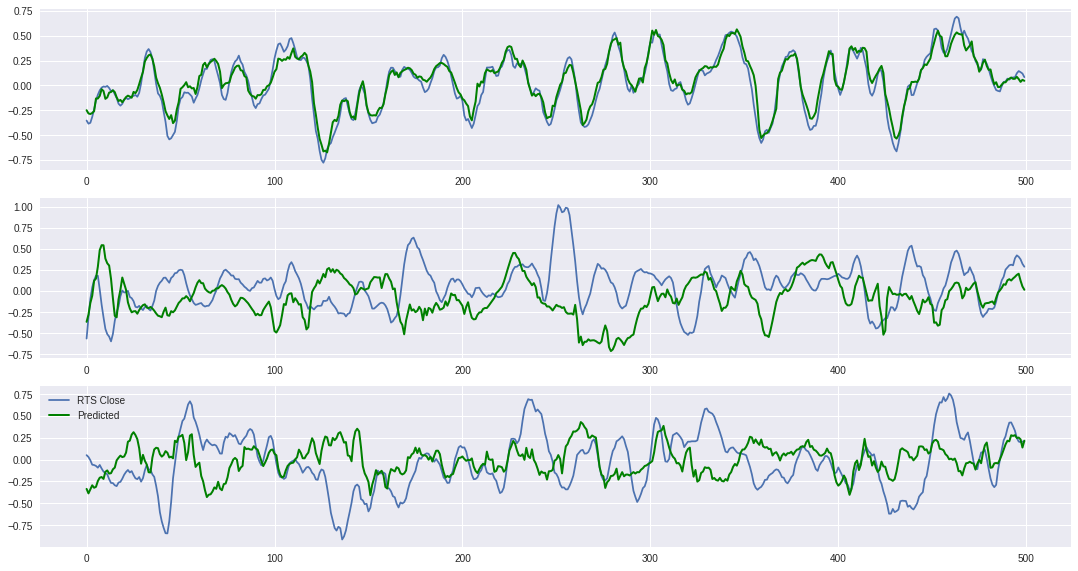

In [57]:
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

train_eval = model.evaluate(X_train, y_train, verbose=1)
val_eval = model.evaluate(X_val, y_val, verbose=1)
test_eval = model.evaluate(X_test, y_test, verbose=1)

fig = plt.figure(figsize=(15,8))
st = 500
p = 500
 
ax11 = fig.add_subplot(311)
ax11.plot(y_train[st: st+p], label='RTS Close')
ax11.plot(train_pred[st:st+p], color='green', linewidth=2, label='Predicted')
ax21 = fig.add_subplot(312)
ax21.plot(y_val[st: st+p], label='RTS Close')
ax21.plot(val_pred[st: st+p], color='green', linewidth=2, label='Predicted')
ax31 = fig.add_subplot(313)
ax31.plot(y_test[st: st+p], label='RTS Close')
ax31.plot(test_pred[st: st+p], color='green', linewidth=2, label='Predicted')
 
plt.tight_layout()
plt.legend(loc='best')

model.save_weights("part2_models/lstm_conv1d.ckpt")
#model.load_weights("part2_models/simple_lstm.ckpt")

# Evaluation

121/121 [==============================] - 1s 6ms/step - loss: 0.1606 - mae: 0.3128


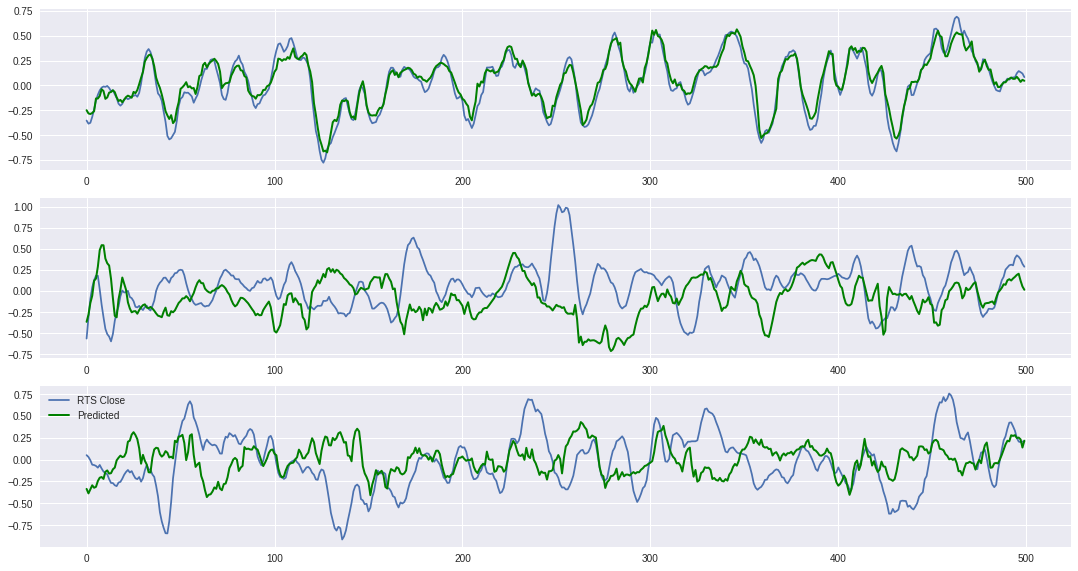

In [ ]:
model.load_weights("part2_models/lstm_conv1d/lstm_conv1d.ckpt")

train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

train_eval = model.evaluate(X_train, y_train, verbose=1)
val_eval = model.evaluate(X_val, y_val, verbose=1)
test_eval = model.evaluate(X_test, y_test, verbose=1)

fig = plt.figure(figsize=(15,8))
st = 500
p = 500
 
ax11 = fig.add_subplot(311)
ax11.plot(y_train[st: st+p], label='RTS Close')
ax11.plot(train_pred[st:st+p], color='green', linewidth=2, label='Predicted')
ax21 = fig.add_subplot(312)
ax21.plot(y_val[st: st+p], label='RTS Close')
ax21.plot(val_pred[st: st+p], color='green', linewidth=2, label='Predicted')
ax31 = fig.add_subplot(313)
ax31.plot(y_test[st: st+p], label='RTS Close')
ax31.plot(test_pred[st: st+p], color='green', linewidth=2, label='Predicted')
 
plt.tight_layout()
plt.legend(loc='best')


# Time Dist. Dense Layers

In [75]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer

class T2V(Layer):
    
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.W = self.add_weight(name='W', shape=(input_shape[-1], self.output_dim), 
                                 initializer='uniform', trainable=True)
        self.P = self.add_weight(name='P', shape=(input_shape[1], self.output_dim), 
                                 initializer='uniform', trainable=True)
        self.w = self.add_weight(name='w', shape=(input_shape[1], 1), 
                                 initializer='uniform', trainable=True)
        self.p = self.add_weight(name='p', shape=(input_shape[1], 1), 
                                 initializer='uniform', trainable=True)
        super(T2V, self).build(input_shape)
    
    def call(self, x):
        original = self.w * x + self.p
        sin_trans = K.sin(K.dot(x, self.W) + self.P)
        return K.concatenate([sin_trans, original], -1)

In [78]:
def make_model():

    inp = Input(shape=(seq_len,X_train.shape[2]))
    x = BatchNormalization()(inp)
    time = Lambda(lambda x: x[:, :, :1])(x)
    feat = Lambda(lambda x: x[:, :, 1:X_train.shape[2]])(x)
    x = T2V(4)(time)
    x = Concatenate()([x, feat])

    x = TimeDistributed(Dense(32, activation = None))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = TimeDistributed(Dense(32, activation = None))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    xx = TimeDistributed(Dense(64, activation = None))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    

    x = LSTM(128, return_sequences = False)(x)
    x = BatchNormalization()(x)

    x = Dense(96, activation = partial(tf.nn.leaky_relu, alpha=0.01))(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation = partial(tf.nn.leaky_relu, alpha=0.01))(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation = partial(tf.nn.leaky_relu, alpha=0.01))(x)
    out = Dense(1)(x)
    model = Model(inp, out)
    model.compile(loss='mse', 
                  optimizer=tf.keras.optimizers.Adam(), 
                  metrics = ['mae'])
    return model

# Training Part

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 30)]    0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 30)     120         ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 lambda (Lambda)                (None, 128, 1)       0           ['batch_normalization[0][0]']    
                                                                                                  
 t2v (T2V)                      (None, 128, 5)       772         ['lambda[0][0]']             

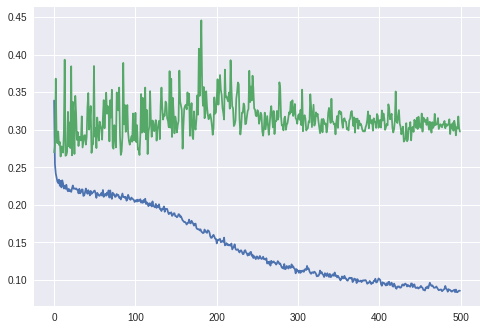

In [79]:
tf.keras.backend.clear_session()
model = make_model()
model.summary()

history = model.fit(X_train, y_train,
          epochs=500,
          validation_data=(X_val, y_val),
          batch_size = 125, 
          verbose = 1,
          steps_per_epoch=40
          )

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])

121/121 [==============================] - 1s 5ms/step - loss: 0.1347 - mae: 0.2884


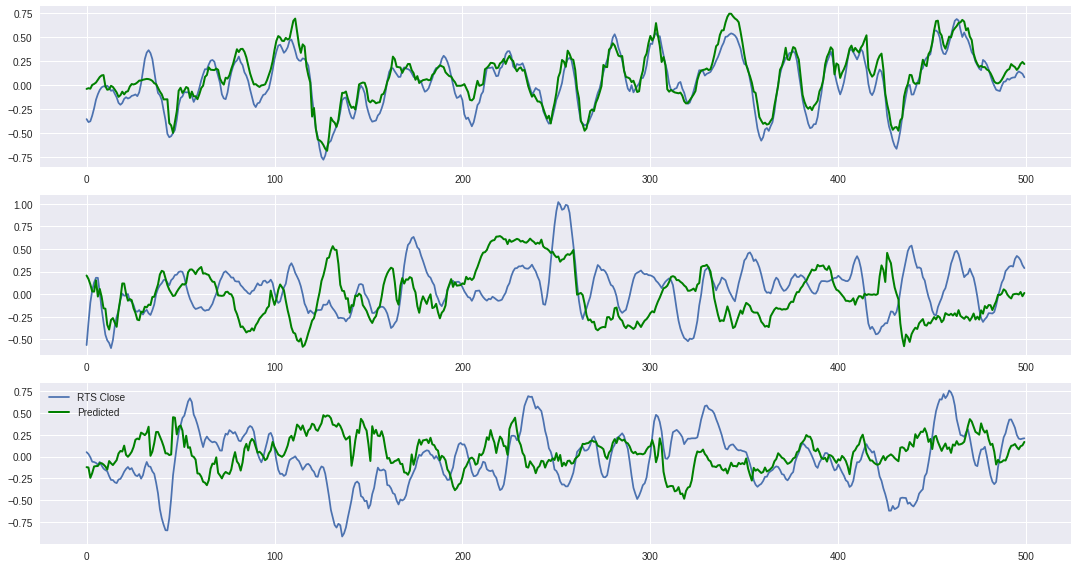

In [80]:
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

train_eval = model.evaluate(X_train, y_train, verbose=1)
val_eval = model.evaluate(X_val, y_val, verbose=1)
test_eval = model.evaluate(X_test, y_test, verbose=1)

fig = plt.figure(figsize=(15,8))
st = 500
p = 500
 
ax11 = fig.add_subplot(311)
ax11.plot(y_train[st: st+p], label='RTS Close')
ax11.plot(train_pred[st:st+p], color='green', linewidth=2, label='Predicted')
ax21 = fig.add_subplot(312)
ax21.plot(y_val[st: st+p], label='RTS Close')
ax21.plot(val_pred[st: st+p], color='green', linewidth=2, label='Predicted')
ax31 = fig.add_subplot(313)
ax31.plot(y_test[st: st+p], label='RTS Close')
ax31.plot(test_pred[st: st+p], color='green', linewidth=2, label='Predicted')
 
plt.tight_layout()
plt.legend(loc='best')

model.save_weights("part2_models/time_dist.ckpt")
#model.load_weights("part2_models/simple_lstm.ckpt")

# Evaluation

121/121 [==============================] - 1s 5ms/step - loss: 0.1347 - mae: 0.2884


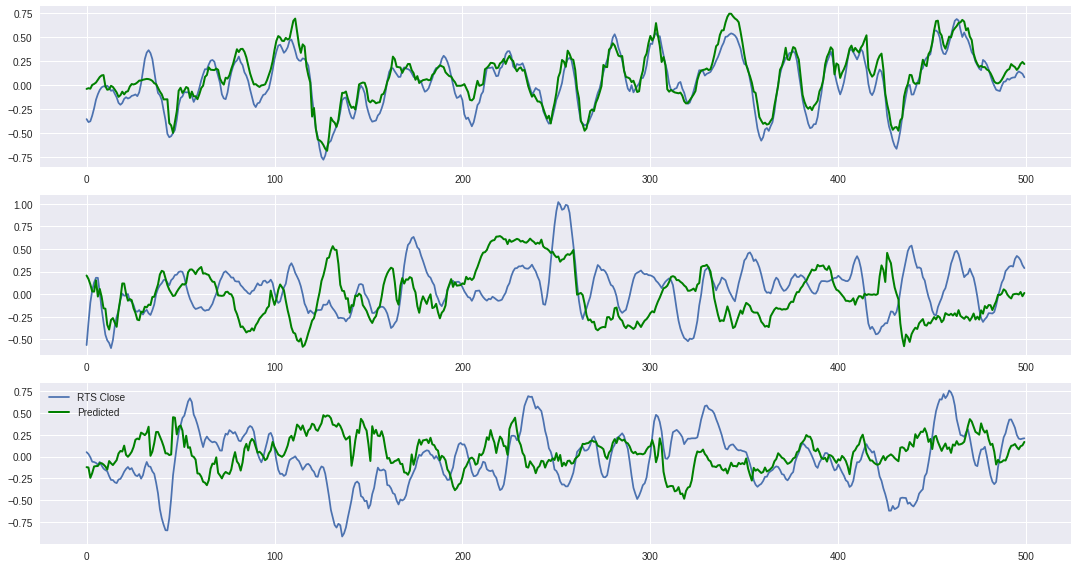

In [ ]:
model.load_weights("part2_models/time_dist/time_dist.ckpt")

train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

train_eval = model.evaluate(X_train, y_train, verbose=1)
val_eval = model.evaluate(X_val, y_val, verbose=1)
test_eval = model.evaluate(X_test, y_test, verbose=1)

fig = plt.figure(figsize=(15,8))
st = 500
p = 500
 
ax11 = fig.add_subplot(311)
ax11.plot(y_train[st: st+p], label='RTS Close')
ax11.plot(train_pred[st:st+p], color='green', linewidth=2, label='Predicted')
ax21 = fig.add_subplot(312)
ax21.plot(y_val[st: st+p], label='RTS Close')
ax21.plot(val_pred[st: st+p], color='green', linewidth=2, label='Predicted')
ax31 = fig.add_subplot(313)
ax31.plot(y_test[st: st+p], label='RTS Close')
ax31.plot(test_pred[st: st+p], color='green', linewidth=2, label='Predicted')
 
plt.tight_layout()
plt.legend(loc='best')

# Large Kernel Convolutions

In [84]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer

class T2V(Layer):
    
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.W = self.add_weight(name='W', shape=(input_shape[-1], self.output_dim), 
                                 initializer='uniform', trainable=True)
        self.P = self.add_weight(name='P', shape=(input_shape[1], self.output_dim), 
                                 initializer='uniform', trainable=True)
        self.w = self.add_weight(name='w', shape=(input_shape[1], 1), 
                                 initializer='uniform', trainable=True)
        self.p = self.add_weight(name='p', shape=(input_shape[1], 1), 
                                 initializer='uniform', trainable=True)
        super(T2V, self).build(input_shape)
    
    def call(self, x):
        original = self.w * x + self.p
        sin_trans = K.sin(K.dot(x, self.W) + self.P)
        return K.concatenate([sin_trans, original], -1)

In [86]:
def make_model(cell_size = 96):

    inp = Input(shape=(seq_len,X_train.shape[2]))
    x = BatchNormalization()(inp)
    time = Lambda(lambda x: x[:, :, :1])(x)
    feat = Lambda(lambda x: x[:, :, 1:X_train.shape[2]])(x)
    x = T2V(4)(time)
    x = Concatenate()([x, feat])

    x = Conv1D(32, kernel_size = 31,)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(32, kernel_size = 21)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(32, kernel_size = 11)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    

    x = LSTM(cell_size, return_sequences = False)(x)
    x = BatchNormalization()(x)

    x = Dense(96, activation = partial(tf.nn.leaky_relu, alpha=0.01))(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation = partial(tf.nn.leaky_relu, alpha=0.01))(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation = partial(tf.nn.leaky_relu, alpha=0.01))(x)
    out = Dense(1)(x)
    model = Model(inp, out)
    model.compile(loss='mse', 
                  optimizer=tf.keras.optimizers.Adam(), 
                  metrics = ['mae'])
    return model

#Training part

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 30)]    0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 30)     120         ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 lambda (Lambda)                (None, 128, 1)       0           ['batch_normalization[0][0]']    
                                                                                                  
 t2v (T2V)                      (None, 128, 5)       772         ['lambda[0][0]']             

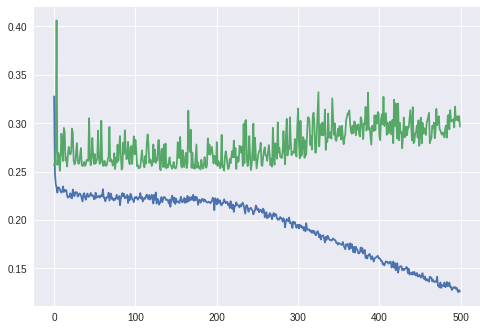

In [88]:
tf.keras.backend.clear_session()
model = make_model()
model.summary()

history = model.fit(X_train, y_train,
          epochs=500,
          validation_data=(X_val, y_val),
          batch_size = 125, 
          verbose = 1,
          steps_per_epoch=40
          )

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])

121/121 [==============================] - 1s 5ms/step - loss: 0.1999 - mae: 0.3597


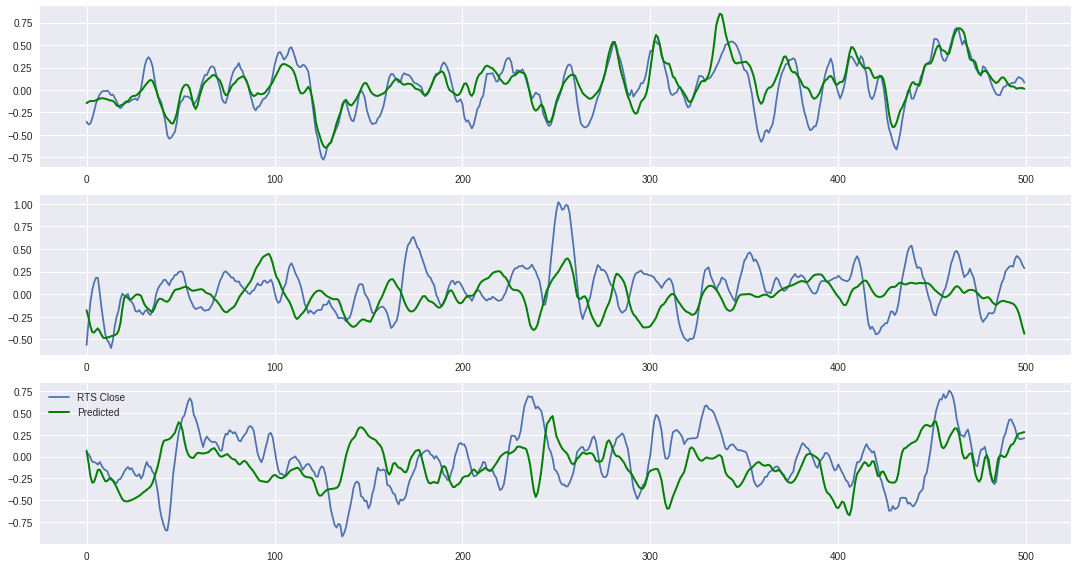

In [89]:
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

train_eval = model.evaluate(X_train, y_train, verbose=1)
val_eval = model.evaluate(X_val, y_val, verbose=1)
test_eval = model.evaluate(X_test, y_test, verbose=1)

fig = plt.figure(figsize=(15,8))
st = 500
p = 500
 
ax11 = fig.add_subplot(311)
ax11.plot(y_train[st: st+p], label='RTS Close')
ax11.plot(train_pred[st:st+p], color='green', linewidth=2, label='Predicted')
ax21 = fig.add_subplot(312)
ax21.plot(y_val[st: st+p], label='RTS Close')
ax21.plot(val_pred[st: st+p], color='green', linewidth=2, label='Predicted')
ax31 = fig.add_subplot(313)
ax31.plot(y_test[st: st+p], label='RTS Close')
ax31.plot(test_pred[st: st+p], color='green', linewidth=2, label='Predicted')
 
plt.tight_layout()
plt.legend(loc='best')

model.save_weights("part2_models/large_ker.ckpt")
#model.load_weights("part2_models/simple_lstm.ckpt")

#Evaluation

121/121 [==============================] - 1s 5ms/step - loss: 0.1999 - mae: 0.3597


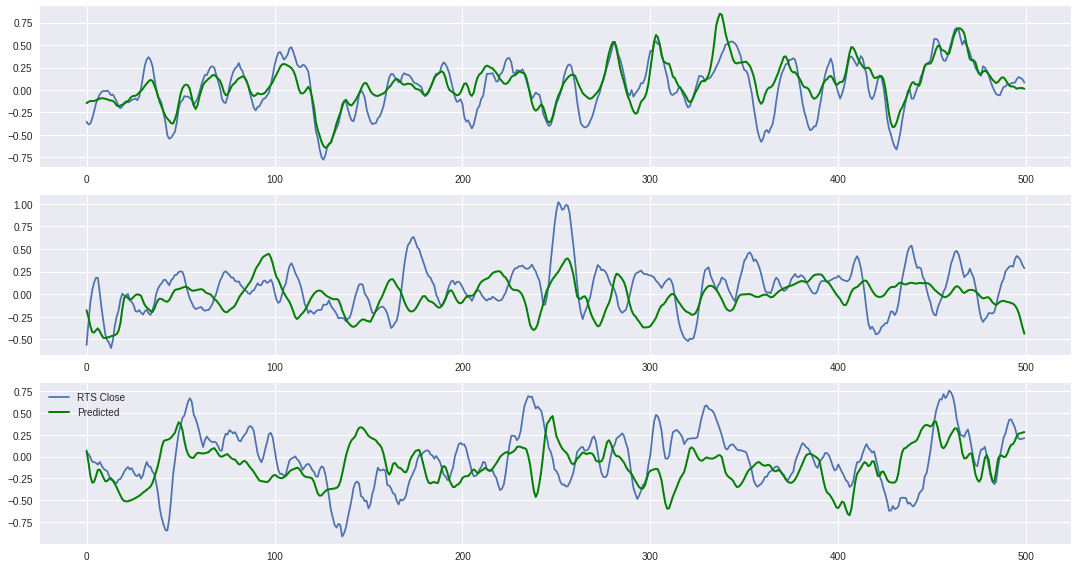

In [ ]:
model.load_weights("part2_models/large_ker/large_ker.ckpt")

train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

train_eval = model.evaluate(X_train, y_train, verbose=1)
val_eval = model.evaluate(X_val, y_val, verbose=1)
test_eval = model.evaluate(X_test, y_test, verbose=1)

fig = plt.figure(figsize=(15,8))
st = 500
p = 500
 
ax11 = fig.add_subplot(311)
ax11.plot(y_train[st: st+p], label='RTS Close')
ax11.plot(train_pred[st:st+p], color='green', linewidth=2, label='Predicted')
ax21 = fig.add_subplot(312)
ax21.plot(y_val[st: st+p], label='RTS Close')
ax21.plot(val_pred[st: st+p], color='green', linewidth=2, label='Predicted')
ax31 = fig.add_subplot(313)
ax31.plot(y_test[st: st+p], label='RTS Close')
ax31.plot(test_pred[st: st+p], color='green', linewidth=2, label='Predicted')
 
plt.tight_layout()
plt.legend(loc='best')